In [1]:
from gensim.models.keyedvectors import KeyedVectors

word2VecModel = KeyedVectors.load_word2vec_format('D:/gn/GoogleNews-vectors-negative300.bin', binary=True)

angry = word2VecModel['angry']
disgust = word2VecModel['disgust']
fear = word2VecModel['fear']
happy = word2VecModel['happy']
neutral = word2VecModel['neutral']
sad = word2VecModel['sad']
surprise = word2VecModel['surprise']

weight = [angry, disgust, fear, happy, neutral, sad, surprise]


In [2]:
import tensorflow
print(tensorflow.test.is_built_with_cuda())
print(tensorflow.test.is_built_with_gpu_support())

True
True


In [3]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

print("a")

a


In [4]:
train_dir = "images/train" #passing the path with training images
test_dir = "images/validation"   #passing the path with testing images

In [192]:
img_size = 48 #original size of the image
_batch_size = 16

In [6]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                height_shift_range = 0.1,
                                horizontal_flip = True,
                                rescale = 1./255,
                                validation_split = 0.2,)
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [198]:
"""
Applying data augmentation to the images as we read 
them from their respective directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    class_mode = "categorical",
                                                    color_mode = "grayscale",
                                                    subset = "training",
                                                    batch_size=_batch_size
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              class_mode = "categorical",
                                                              color_mode = "grayscale",
                                                              subset = "validation",
                                                              batch_size=_batch_size
                                                             )

Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [171]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            w = -100
            for n in range(len(weight) - 1) : 
                a = cosine_similarity(a, y_pred)
                if w < a :
                    w = a
                    y_pred = n
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)

class NumLoss(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        difference = 0.
        for n in range(len(y_true.numpy().tolist())-1) : 
            y_true_n = y_true.numpy().tolist()[n]
            y_pred_n = y_pred.numpy().tolist()[n]
            difference += abs(weight[int(y_true_n[0])] - y_pred_n)
        m = tf.reduce_mean(difference / _batch_size) 
        print(m)
        return m

class WeightLayer(keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(WeightLayer, self).build(input_shape)

    def call(self, x):
        return keras.backend.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


m_input = keras.Input(shape=(img_size, img_size, 1))
x = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(m_input)

x = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)
m_output = keras.layers.Dense(300, activation='relu')

model = CustomModel(m_input, m_output)

In [206]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(300,activation = 'softmax'))
#model.add(WeightLayer(7))
#model.add(Dense(7, activation='softmax'))

In [114]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Flatten()) 
model.add(Dense(300, activation = 'softmax'))

In [83]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}



cosine_loss = tf.keras.losses.CosineSimilarity()

class NumLoss(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        y_true_n = y_true.numpy().tolist()[0]
        y_pred_n = y_pred.numpy().tolist()[0]
        difference_n = abs(cosine_loss(weight[int(y_true_n[0])], y_pred_n).numpy())
        for n in range(1, len(y_true.numpy().tolist())-2) : 
            y_true_n = y_true.numpy().tolist()[n]
            y_pred_n = y_pred.numpy().tolist()[n]
            difference = abs(cosine_loss(weight[int(y_true_n[0])], y_pred_n).numpy())
            difference_n = difference + difference_n
        m = difference_n / _batch_size
        return m

In [104]:


cosine_loss = tf.keras.losses.CosineSimilarity()

class NumLoss(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        for n in range(len(y_true.numpy().tolist())-1) : 
            y_true_n = y_true.numpy().tolist()[n]
            y_pred_n = y_pred.numpy().tolist()[n]
            difference = cosine_loss(weight[int(y_true_n[0])], y_pred_n)
            m = tf.reduce_sum(difference)
        return tf.reduce_mean(m)

In [199]:

def category_accuracy():
    def recall(y_true, y_pred):
        for n in range(len(y_true.numpy().tolist())-1) : 
            y_pred_n = y_pred.numpy().tolist()[n]
            y_true_n = y_true.numpy().tolist()[n]
            score = 0
            i = 0
            w = 0.00
            for m in range(len(weight)) : 
                a = cosine_similarity(weight[m], y_pred_n)
                if w < a : 
                    w = a
                    i = m
            if i == y_true_n.index(int(max(y_true_n))) :
                score += 1
        return score / _batch_size
    return recall

In [207]:
model.compile(
    run_eagerly = True,
    optimizer = Adam(learning_rate=0.0001), 
    loss=NumLoss(),
    metrics=[category_accuracy()]
  )

In [187]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 flatten_8 (Flatten)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 300)               22118700  
                                                                 
Total params: 22,119,020
Trainable params: 22,119,020
Non-trainable params: 0
_________________________________________________________________
None


In [203]:
epochs = 5
batch_size=_batch_size

In [208]:
history = model.fit(x = train_generator, epochs = epochs, validation_data = validation_generator)

Epoch 1/5
361/361 [==============================] - 110s 303ms/step - loss: 1.6204 - recall: 0.0032 - val_loss: 0.0470 - val_recall: 0.0000e+00
Epoch 2/5
361/361 [==============================] - 110s 305ms/step - loss: 0.0123 - recall: 0.0024 - val_loss: 0.0014 - val_recall: 0.0041
Epoch 3/5
361/361 [==============================] - 111s 307ms/step - loss: 0.0014 - recall: 0.0026 - val_loss: 0.0043 - val_recall: 0.0034
Epoch 4/5
361/361 [==============================] - 111s 308ms/step - loss: -2.6639e-04 - recall: 0.0024 - val_loss: 0.0073 - val_recall: 0.0027
Epoch 5/5
361/361 [==============================] - 112s 309ms/step - loss: 0.0020 - recall: 0.0031 - val_loss: 0.0043 - val_recall: 0.0034


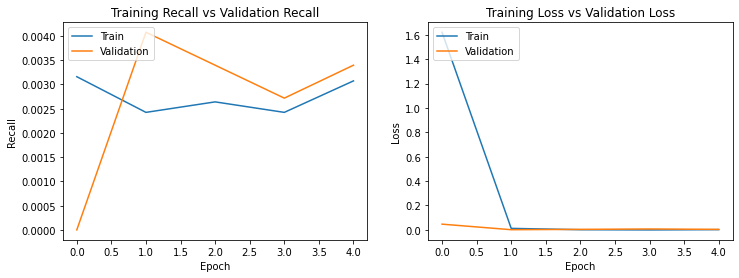

In [209]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['recall']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['recall'])
ax[0].plot(history.history['val_recall'])
ax[0].set_title('Training Recall vs Validation Recall')
ax[0].set_ylabel('Recall')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [210]:
model.save('model_optimal.h5')

In [211]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train recall = {:.2f} , validation recall = {:.2f} , train_loss = {:.2f} , validation_loss = {:.2f}".format(train_acc*100, test_acc*100, train_loss, test_loss))

23/23 [==============================] - 6s 267ms/step - loss: 0.0012 - recall: 0.0020
final train recall = 0.25 , validation recall = 0.20 , train_loss = 0.00 , validation_loss = 0.00


In [ ]:
model.save_weights('model_weights.h5')